# Comparison of Time Series, Machine Learning and Deep Learning models

## 1. Introduction

Various models will be explored to forecast Adjusted Close prices for Crude Oil stock price data from simple machine learning algorithms such as Moving Average, Linear Regression and k-Nearest Neighbours, to Auto ARIMA, Facebook's Prophet and LSTM.  


## 2. Install/import libraries

In [1]:
# !pip install yfinance 
# !pip install pmdarima
# !pip install prophet

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pmdarima import auto_arima
# from fbprophet import Prophet
import prophet 
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta


## 3. Import data


Read in Crude Oil stock data downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame. 

In [2]:
df = yf.download("CL=F", start="2010-01-01", end="2023-01-15")
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-09,73.470001,76.739998,73.470001,74.629997,74.629997,329290
2023-01-10,74.860001,75.919998,73.839996,75.120003,75.120003,307430
2023-01-11,74.779999,77.839996,74.309998,77.410004,77.410004,350891
2023-01-12,77.699997,79.160004,77.099998,78.389999,78.389999,307705
2023-01-13,78.320000,80.110001,77.970001,79.860001,79.860001,307705


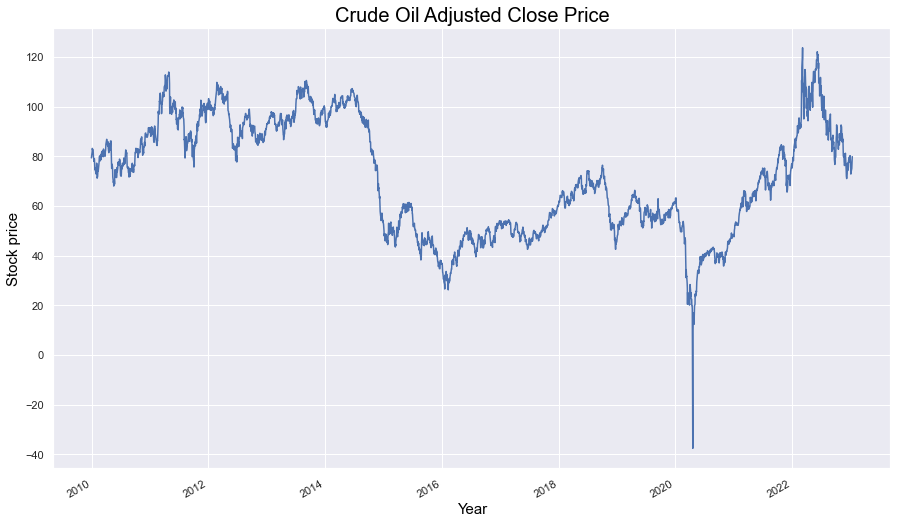

In [5]:
# Plot Adjusted Close price

df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title('Crude Oil Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## 4. Moving Average

We will start with a simple moving average model whereby the next observation is the mean of all past observations creating a constantly updated average price.



In [6]:
# Create DataFrame for Adjusted Close price

df_adj = df[['Adj Close']]
df_adj 

,Adj Close
Date,
2009-12-31,79.360001
2010-01-04,81.510002
2010-01-05,81.769997
2010-01-06,83.180000
2010-01-07,82.660004
...,...
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004



### Split the data

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [7]:
# Creating 80%/20% split

split = int(0.8*len(df_adj))

In [8]:
# Splitting into train and test

train, test = df_adj[:split], df_adj[split:]

In [9]:
df_adj.shape, train.shape, test.shape

((3282, 1), (2625, 1), (657, 1))

In [10]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2009-12-31 00:00:00'),
 Timestamp('2020-06-09 00:00:00'),
 Timestamp('2020-06-10 00:00:00'),
 Timestamp('2023-01-13 00:00:00'))

### Create predictions for the test set

In [11]:
# Make predictions
preds = []
for i in range(0,657):
    a = train[len(train)-657+i:].sum() + sum(preds)
    b = a/657
    preds.append(b)

### Calculate the RMSE using the actual values

We will evaluate the model by calculating the RMSE, or the standard deviation of the residuals, a good measure of how accurately the model predicts the reponse.

In [12]:
# Calculate rmse
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

30.81279974869249

### Visualise predicted values along with the actual values

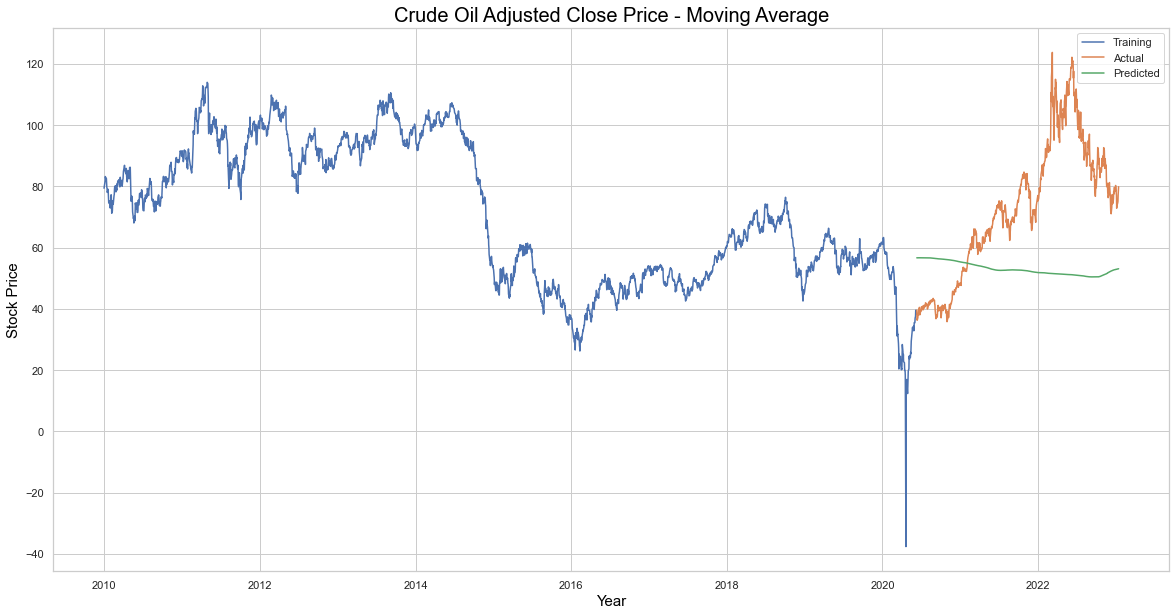

In [13]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Adjusted Close Price - Moving Average", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

The predicted values show an increasing trend initially, then level off and gradually start to decline.

## 5. Linear Regression

This model adopts a linear approach to modelling the relationship between a dependent variable and independent variable(s), and is also the simplest form of machine learning.

In [14]:
# Setting index as date values in a Date column
df_adj['Date'] = pd.to_datetime(df_adj.index, format='%Y-%m-%d')
df_adj.index = df_adj['Date']

In [15]:
# Creating a separate dataset for Adjusted Close prices
df_adj = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
     df_adj['Date'][i] = df.index[i]
     df_adj['Adj Close'][i] = df['Adj Close'][i]

### Feature engineering

The hypothesis here is that the first and last days of the week could potentially affect the Adjusted Close price of the stock far more than the days in between. We will create a feature that identifies whether a given day is a Monday or Friday, or a Tuesday, Wednesday or Thursday.

If the day of week is equal to 0 (Monday) or 4 (Friday), the column value will be 1, otherwise 0 for Tuesday, Wednesday, Thursday. 

In [16]:
def add_datepart(df, fldname, drop=True, time=False):
    """
    Helper function that adds columns relevant to a date.
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [17]:
# Call function to add columns
add_datepart(df_adj, 'Date')
df_adj.drop('Elapsed', axis=1, inplace=True)  # Elapsed is the time stamp

In [18]:
# Print new columns
df_adj.columns

Index(['Adj Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [19]:
# Create features
df_adj['mon_fri'] = 0
for i in range(0,len(df_adj)):
    if (df_adj['Dayofweek'][i] == 0 or df_adj['Dayofweek'][i] == 4):
        df_adj['mon_fri'][i] = 1
    else:
        df_adj['mon_fri'][i] = 0

### Split the data into train and test sets 

In [20]:
split = int(0.8*len(df_adj))

In [21]:
train, test = df_adj[:split], df_adj[split:]

In [22]:
df_adj.shape, train.shape, test.shape

((3282, 14), (2625, 14), (657, 14))

In [23]:
X_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
X_test = test.drop('Adj Close', axis=1)
y_test = test['Adj Close']

In [24]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2625, 13), (2625,), (657, 13), (657,))

### Create and train Linear Regression model


In [25]:
# Create model
model = LinearRegression()

# Train model
model.fit(X_train,y_train)

LinearRegression()

### Test model

In [26]:
# Make predictions 
preds = model.predict(X_test)

### Calculate the RMSE using the actual values

In [27]:
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

43.55404289568718

### Visualise predicted values along with the actual values

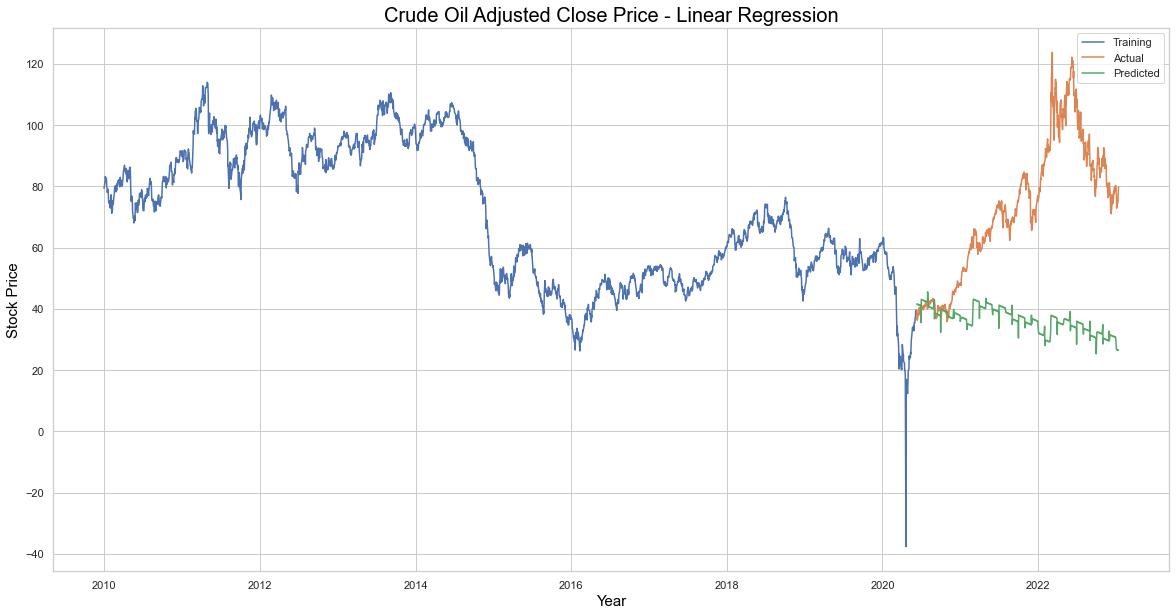

In [28]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = df[split:].index
train.index = df[:split].index

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Adjusted Close Price - Linear Regression", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

The RMSE value is lower than the Moving Average technique, but the plot for the Linear Regression model still doesn't look too promising.

## 6. k-Nearest Neighbours

Based on the independent variables, k-Nearest Neighbours finds the similarity between new and old data points and assumes that similar data points exist in close proximity. It chooses the k closest neighbours and then based on these neighbours predicts a value for a new observation.

### Feature scaling

In [29]:
# Normalisation - rescaling of the data so that all values are within the range of 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test) 
X_test = pd.DataFrame(X_test_scaled)

### GridSearch cross validation to find optimum parameter

In [30]:
# Create dictionary of parameters
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
# Create model
knn = KNeighborsRegressor()
# Use GridSearch to find the best parameter
model = GridSearchCV(knn, params, cv=5)

### Train and test model

In [31]:
# Fit the model and make predictions
model.fit(X_train,y_train)
preds = model.predict(X_test)

### Calculate the RMSE using the actual values

In [32]:
# rmse
rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
rmse

35.73339509225106

### Visualise predicted values along with the actual values

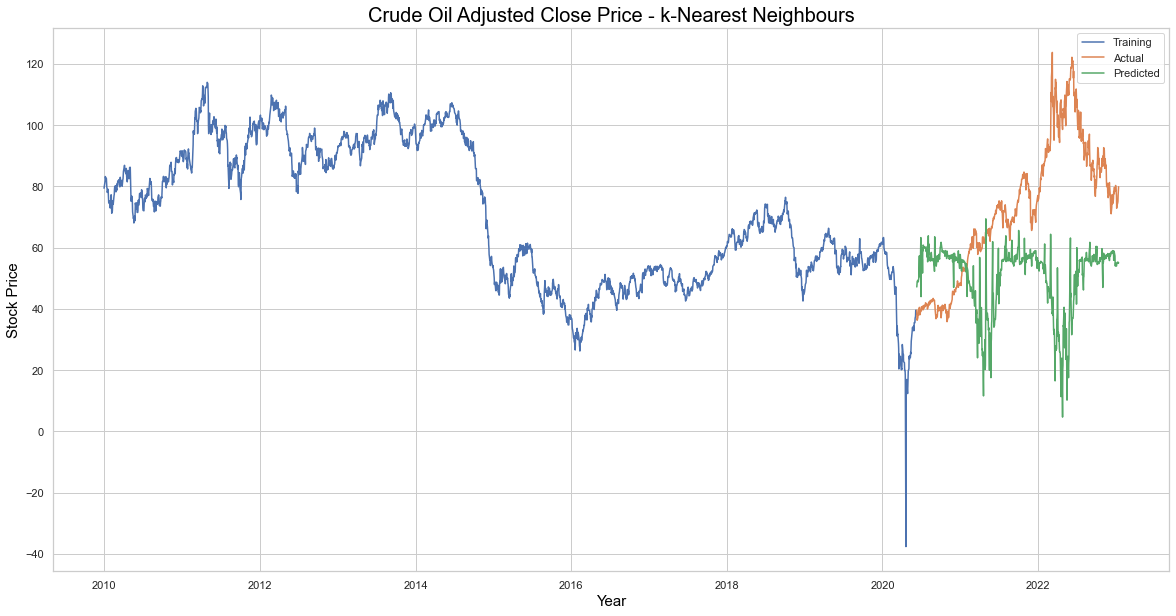

In [33]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Adjusted Close Price - k-Nearest Neighbours", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

From the above three plots it appears that regression algorithms have not performed well on this time series data set.

## 7. Auto ARIMA

Auto Regressive Integrated Moving Average (ARIMA) models explains a given time series based on its own past values, that is, its own lags (p) and the lagged forecast errors (q), so that equation can be used to forecast future values. The 'd' parameter represents the number of times that the data have to be differenced to produce a stationary signal that has a constant mean over time. This captures the integrated nature of ARIMA.

Auto ARIMA automatically generates the optimal combination of (p,q,d) which would be suitable for the data set to provide better forecasting.

In [34]:
# Create Adjusted Close price DataFrame

df_adj = df[['Adj Close']]
df_adj 

,Adj Close
Date,
2009-12-31,79.360001
2010-01-04,81.510002
2010-01-05,81.769997
2010-01-06,83.180000
2010-01-07,82.660004
...,...
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004


### Split the data into train and test sets

In [35]:
split = int(0.8*len(df_adj))

In [36]:
train, test = df_adj[:split], df_adj[split:]

In [37]:
df_adj.shape, train.shape, test.shape

((3282, 1), (2625, 1), (657, 1))

### Create, train and test model

In [38]:
# Create model to find best parameters
model = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
# Train model
model.fit(train)
# Make predictions on test set
forecast = model.predict(n_periods=657)
# Create DataFrame for Predictions
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.64 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12776.699, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11884.318, Time=0.48 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=12625.946, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=11430.339, Time=1.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.71 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=11571.809, Time=0.80 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=11419.337, Time=2.56 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=11866.631, Time=0.80 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=6.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.88 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=11416.984, Time=2.94 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AI

### Calculate the RMSE using the actual values

In [39]:
rmse = np.sqrt(np.mean(np.power((np.array(test['Adj Close'])-np.array(forecast['Prediction'])),2)))
rmse

173.4946043594886

### Print results and plot residuals of optimised model

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 3282
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -6899.177
Date:                Sun, 15 Jan 2023   AIC                          13806.354
Time:                        09:56:48   BIC                          13830.738
Sample:                             0   HQIC                         13815.085
                               - 3282                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2024      0.002   -101.338      0.000      -0.206      -0.198
ar.L2         -0.0693      0.006    -10.721      0.000      -0.082      -0.057
ar.L3         -0.0397      0.010     -3.877      0.0

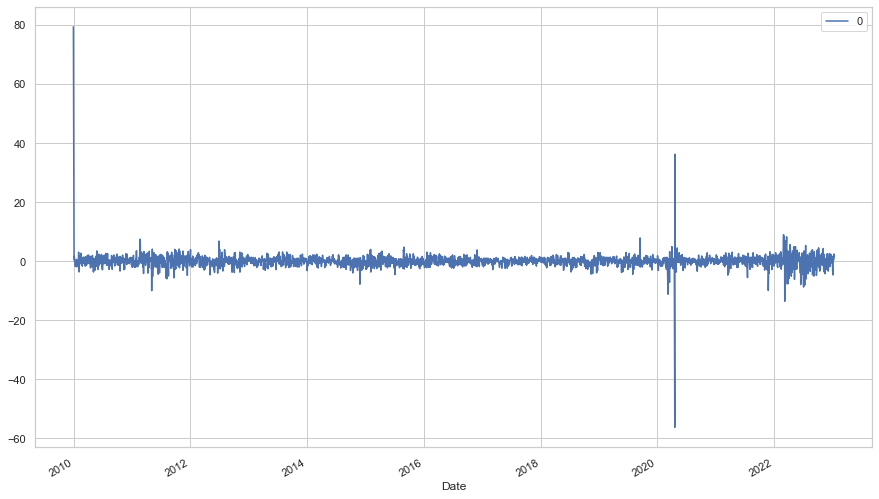

In [40]:
# Create model with best parameters and print results
# model = ARIMA(df_adj['Adj Close'], order=(3,1,0))

import statsmodels.api
model = statsmodels.tsa.arima.model.ARIMA(df_adj['Adj Close'], order=(3,1,0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot();

### Visualise predicted values along with the actual values

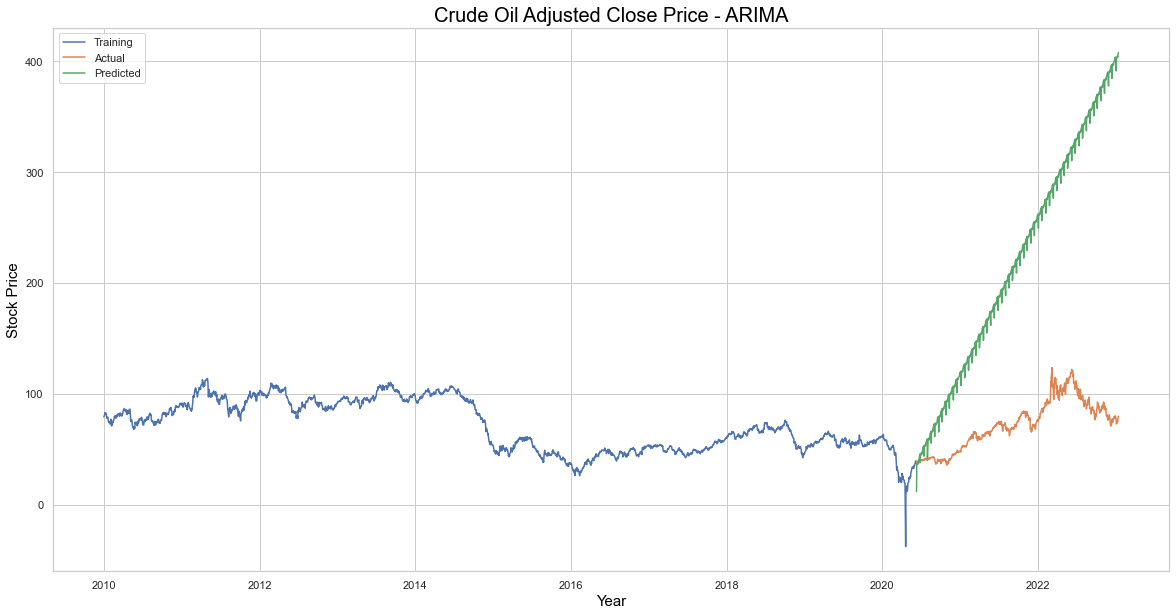

In [41]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(forecast['Prediction'], label='Predicted')
plt.title("Crude Oil Adjusted Close Price - ARIMA", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

By using past data to understand the pattern in the time series the model has captured an increasing trend in the series and achieved the lowest RMSE so far but still does not perform very well. 



## 8. Prophet

Here we will implement a time series model that takes both trend and seasonality of a series into account. Facebook's Prophet is a package for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.

### Prepare and format data

In [42]:
# Create data set with Adjusted CLose and Date Columns
df_adj = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(df)):
     df_adj['Date'][i] = df.index[i]
     df_adj['Adj Close'][i] = df['Adj Close'][i]

In [43]:
# Format date
df_adj['Date'] = pd.to_datetime(df_adj.Date,format='%Y-%m-%d')
df_adj.index = df_adj['Date']

The input to Prophet is always a dataframe with two columns: **ds** and **y**. The **ds** (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date. The **y** column must be numeric, and represents the measurement we wish to forecast.

In [44]:
# Preparing data
df_adj.rename(columns={'Adj Close': 'y', 'Date': 'ds'}, inplace=True)

### Split the data into train and test sets

In [45]:
split = int(0.8*len(df_adj))

In [46]:
train, test = df_adj[:split], df_adj[split:]

In [47]:
df_adj.shape, train.shape, test.shape

((3282, 2), (2625, 2), (657, 2))

### Create and train model

In [48]:
# Instantiate Prophet object  
from prophet import Prophet

model = Prophet()
# Fit the model
model.fit(train)

09:58:47 - cmdstanpy - INFO - Chain [1] start processing
09:58:49 - cmdstanpy - INFO - Chain [1] done processing


### Test model

Predictions are then made on the DataFrame with the **ds** column containing the dates for which a prediction is to be made. 

In [49]:
# Make predictions  
adj_close_prices = model.make_future_dataframe(periods=len(test))
forecast = model.predict(adj_close_prices)

### Calculate the RMSE using the actual values

In [50]:
#rmse
forecast_test = forecast['yhat'][split:]
rmse = np.sqrt(np.mean(np.power((np.array(test['y'])-np.array(forecast_test)),2)))
rmse

52.601673705501106

### Visualise predicted values along with the actual values

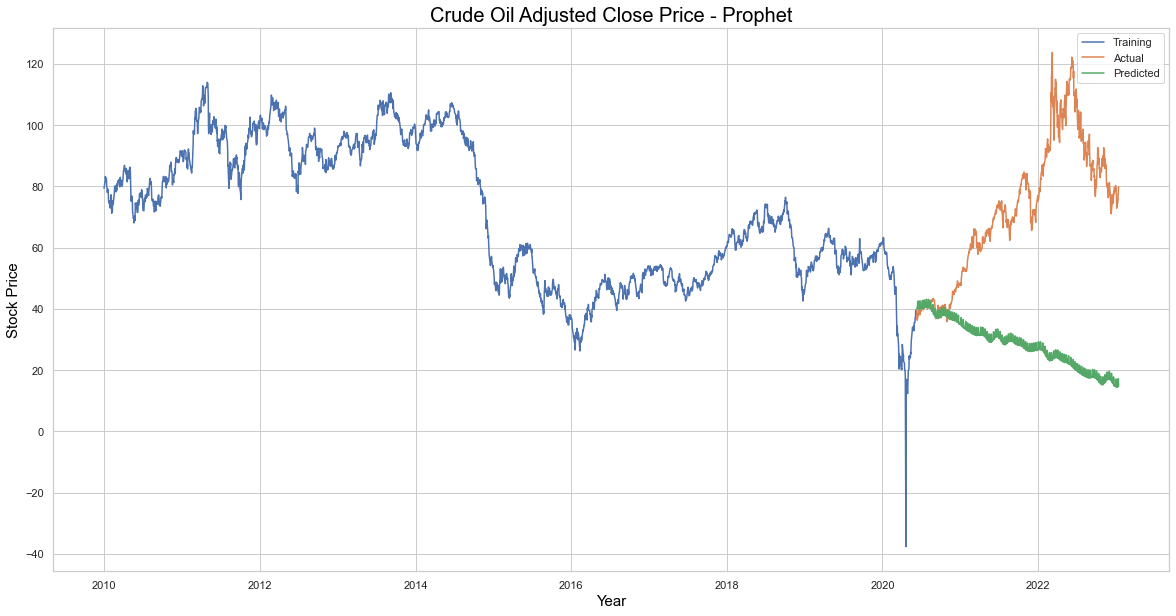

In [51]:
# Plot predicted vs actual values
test['Predictions'] = 0
test['Predictions'] = forecast_test.values

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['y'], label='Training')
plt.plot(test['y'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Adjusted Close Price - Prophet", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

Stock prices do not have a particular trend or seasonality being highly dependent on market forces which cause prices to fluctuate. As a result, forecasting techniques such as ARIMA, SARIMA and Prophet do not yield good results for this particular problem.

We will specify 365 days into the future using the helper method Prophet.make_future_dataframe. By default it will also include the dates from the history, so we will see the model fit as well.

In [52]:
future = model.make_future_dataframe(periods=365)
future.tail()

,ds
2985,2021-06-05
2986,2021-06-06
2987,2021-06-07
2988,2021-06-08
2989,2021-06-09


In [53]:
# Make predictions on future 365 days
forecast = model.predict(future)

The predict method will assign each row in **future** a predicted value which it names **yhat**. If you pass in historical dates, it will provide an in-sample fit. The **forecast** object here is a new DataFrame that includes a column **yhat** with the forecast, as well as columns for components and uncertainty intervals.

In [54]:
# Print forecast object DataFrame

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2985,2021-06-05,28.788879,13.899409,43.059321
2986,2021-06-06,28.748213,12.820510,43.118650
2987,2021-06-07,26.088453,11.166938,40.189958
2988,2021-06-08,26.320972,11.860412,41.085147
2989,2021-06-09,26.207712,11.247670,40.586618


### Plot forecast and trend changepoints

Time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

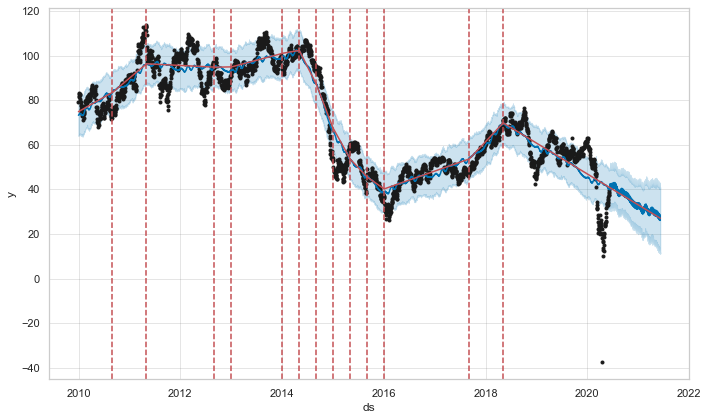

In [55]:
# Plot forecast
fig = model.plot(forecast)
# The change points are added to our plot 
a = add_changepoints_to_plot(fig.gca(), model, forecast)

### Extract changepoints

If we want to use something like this in a model, we need a way of extracting changepoint data.

In [56]:
model.changepoints

84     2010-05-04
168    2010-09-01
252    2010-12-31
336    2011-05-03
420    2011-08-31
504    2011-12-30
588    2012-05-02
672    2012-08-30
756    2013-01-03
840    2013-05-06
924    2013-09-04
1008   2014-01-03
1091   2014-05-05
1175   2014-09-03
1259   2015-01-02
1343   2015-05-05
1427   2015-09-02
1511   2016-01-04
1595   2016-05-04
1679   2016-09-01
1763   2017-01-05
1847   2017-05-08
1931   2017-09-06
2015   2018-01-05
2099   2018-05-08
Name: ds, dtype: datetime64[ns]

### Plot components of the forecasts

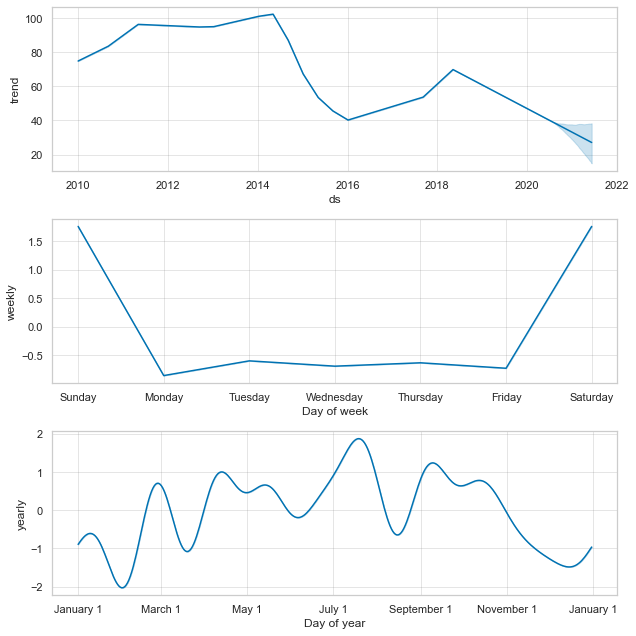

In [57]:
# Plot the trend, weekly and yearly components

model.plot_components(forecast)
plt.show()

Based on the estimated trends, we can see from the yearly subplot that, usually, the stock price appears to be maximum in mid July and, according to the weekly subplot, mostly on Wednesdays.

Finally, the trend subplot shows a steady increase in the stock price for the prediction horizon.



## 9. Long Short Term Memory (LSTM)

An LSTM is a Recurrent Neural Network that is able to store past information that is important, and forget the information that is not. It uses the short-term memory processes to create longer memory and introduces the concept of gates for controlling the flow of information in the network by having input, output and forget gates.

In [58]:
# Create DataFrame for Adjusted Close price
df_adj = df[['Adj Close']]
df_adj 

,Adj Close
Date,
2009-12-31,79.360001
2010-01-04,81.510002
2010-01-05,81.769997
2010-01-06,83.180000
2010-01-07,82.660004
...,...
2023-01-09,74.629997
2023-01-10,75.120003
2023-01-11,77.410004


In [59]:
# Convert DataFrame to numpy array
df_adj_arr = df_adj.values

### Split the data into train and test sets

In [60]:
split = int(0.8*len(df_adj_arr))

In [61]:
train, test = df_adj_arr[:split], df_adj_arr[split:]

In [62]:
train.shape, test.shape

((2625, 1), (657, 1))

### Feature scaling

Normalise data by scaling to a range of 0 to 1 to improve learning and convergence of model.

In [63]:
# Feature scaling and fitting scaled data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_adj_arr)

## Create training data

In [64]:
# Creating a data structure with 60 time-steps and 1 output

X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

In [65]:
# Convert X_train and y_train to numpy arrays for training LSTM model

X_train, y_train = np.array(X_train), np.array(y_train)

In [66]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2565, 60, 1)

### Create and train model

We will implement a simple model comprising one hidden layer with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer, then fitted on the training set for one epoch with a batch size of one.

In [67]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 640 values, using past 60 from the train data
inputs = df_adj_arr [len(df_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

2565/2565 - 39s - loss: 0.0015 - 39s/epoch - 15ms/step


### Create test set

In [68]:
# Create test data set
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Convert data to numpy array
X_test = np.array(X_test)

# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

21/21 [==============================] - 1s 10ms/step


In [69]:
print(X_test.shape)

(657, 60, 1)


### Calculate the RMSE using the actual values

In [70]:
rmse = np.sqrt(np.mean(np.power((test - adj_closing_price),2)))
rmse

4.71277122806792

### Visualise predicted values along with the actual values

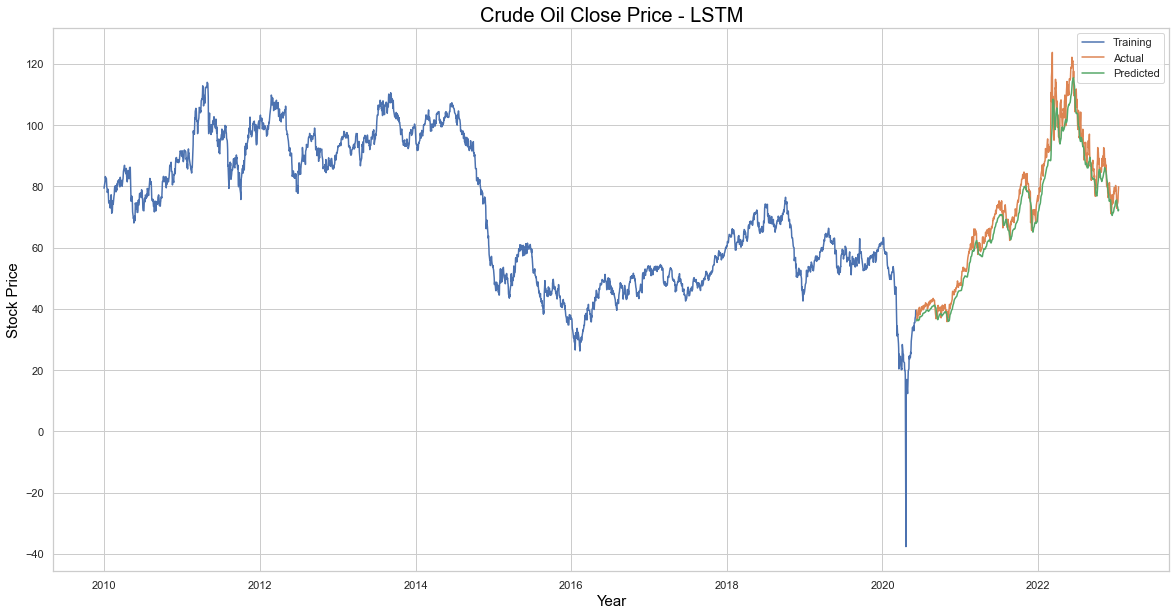

In [72]:
# Plot predicted vs actual values
train = df_adj[:split]
test = df_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Crude Oil Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

The LSTM has achieved the lowest RMSE and the most accurate predictions. This is just a basic model but various parameters can be tuned, more layers added with dropout for regularisation and an increased number of epochs for better convergence. 